# **House Prices Prediction (Kaggle Competition)**

**Author:** Zeteny Cseresznyes  

**Institution:** Central European University, Vienna, Austria

**Course:** UGST4088 — Introduction to Machine Learning and Data Mining 2025/26 Fall

**Contact:** [LinkedIn](https://www.linkedin.com/in/zeteny-cseresznyes-236ba8329/), [GitHub](https://github.com/cseresznyeszeteny)  

*Date:* 11.11.2025.

## **Table of Contents**

1. [Data Preparation and Feature Engineering](#Data-Preparation-and-Feature-Engineering)
2. [Hyperparameter Tuning and Fitting](#Hyperparameter-Tuning-and-Fitting)
3. [Evaluation and Prediction](#Evaluation-and-Prediction)
3. [Discussion](#Discussion)

## **Data Preperation and Feature Engineering**

### Importing Modules

In [23]:
# running timer
import time
start_time = time.time()

# data preperation
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing and pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

# models
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Lasso, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor

# hyperparameter tuning and selection
import optuna as opt
import joblib

# evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split

# rounding up
import math

# save prediction
from datetime import datetime

# warnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore")

### Loading and Splitting the Data

In [24]:
# load data
train_og = pd.read_csv('train.csv')

# split features and target
X = train_og.drop(columns=['SalePrice'])
y = train_og['SalePrice']

# split for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# merge for inspection
train = pd.concat([X_train, y_train.rename("SalePrice")], axis=1)

### Inspection of numeric features

#### *Histograms*

array([[<Axes: title={'center': 'Id'}>,
        <Axes: title={'center': 'MSSubClass'}>,
        <Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>],
       [<Axes: title={'center': 'YearBuilt'}>,
        <Axes: title={'center': 'YearRemodAdd'}>,
        <Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>],
       [<Axes: title={'center': 'TotalBsmtSF'}>,
        <Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtFullBath'}>],
       [<Axes: title={'center': 'BsmtHalfBath'}>,
        <Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'HalfBath'}>,

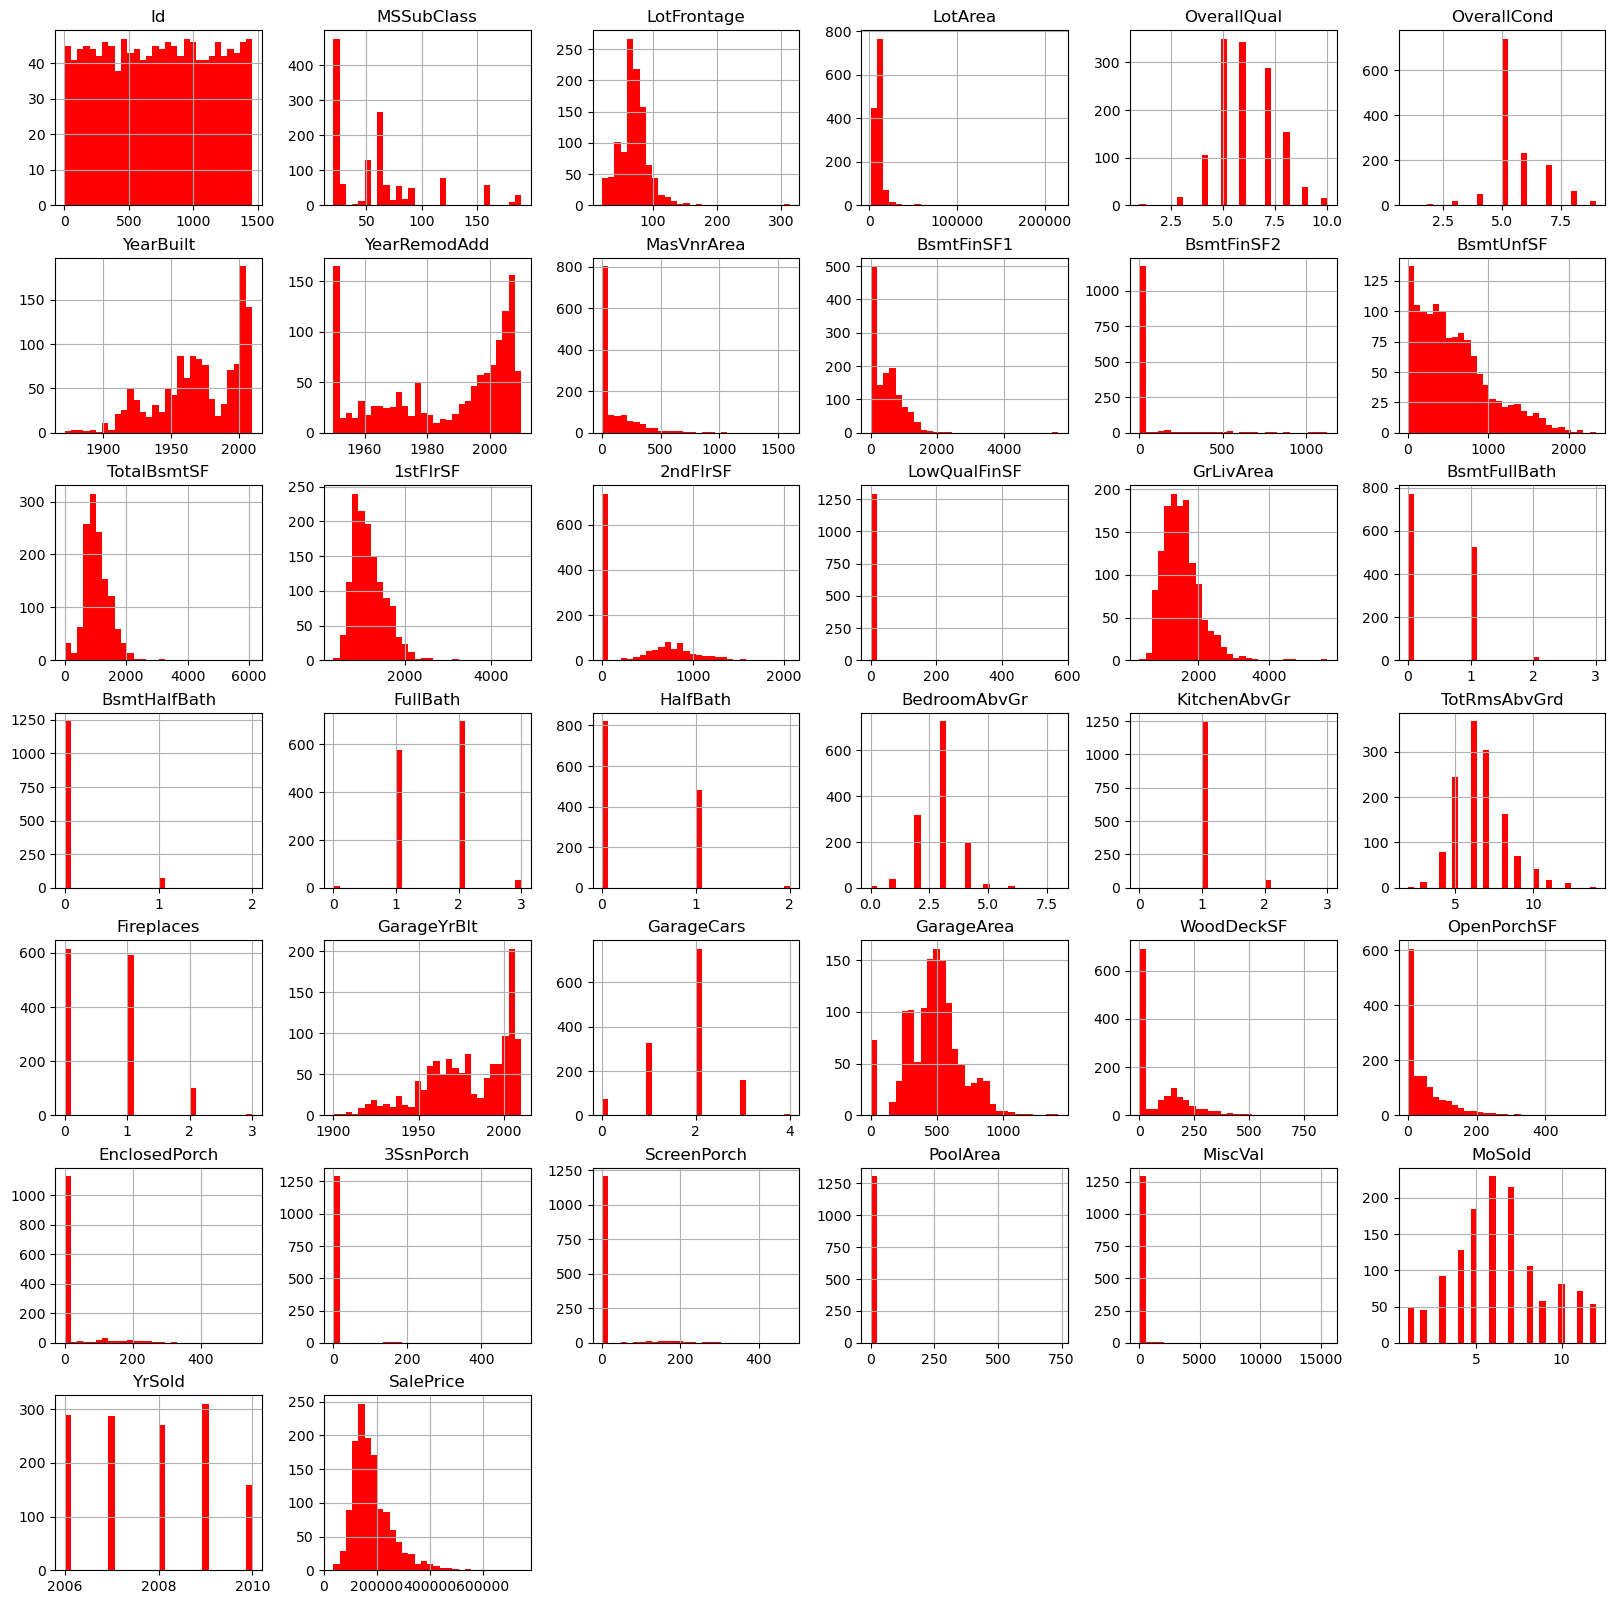

In [25]:
# histograms of all numeric columns
train.hist(figsize=(20, 20), bins=30, color='red')

#### *Scatterplots*

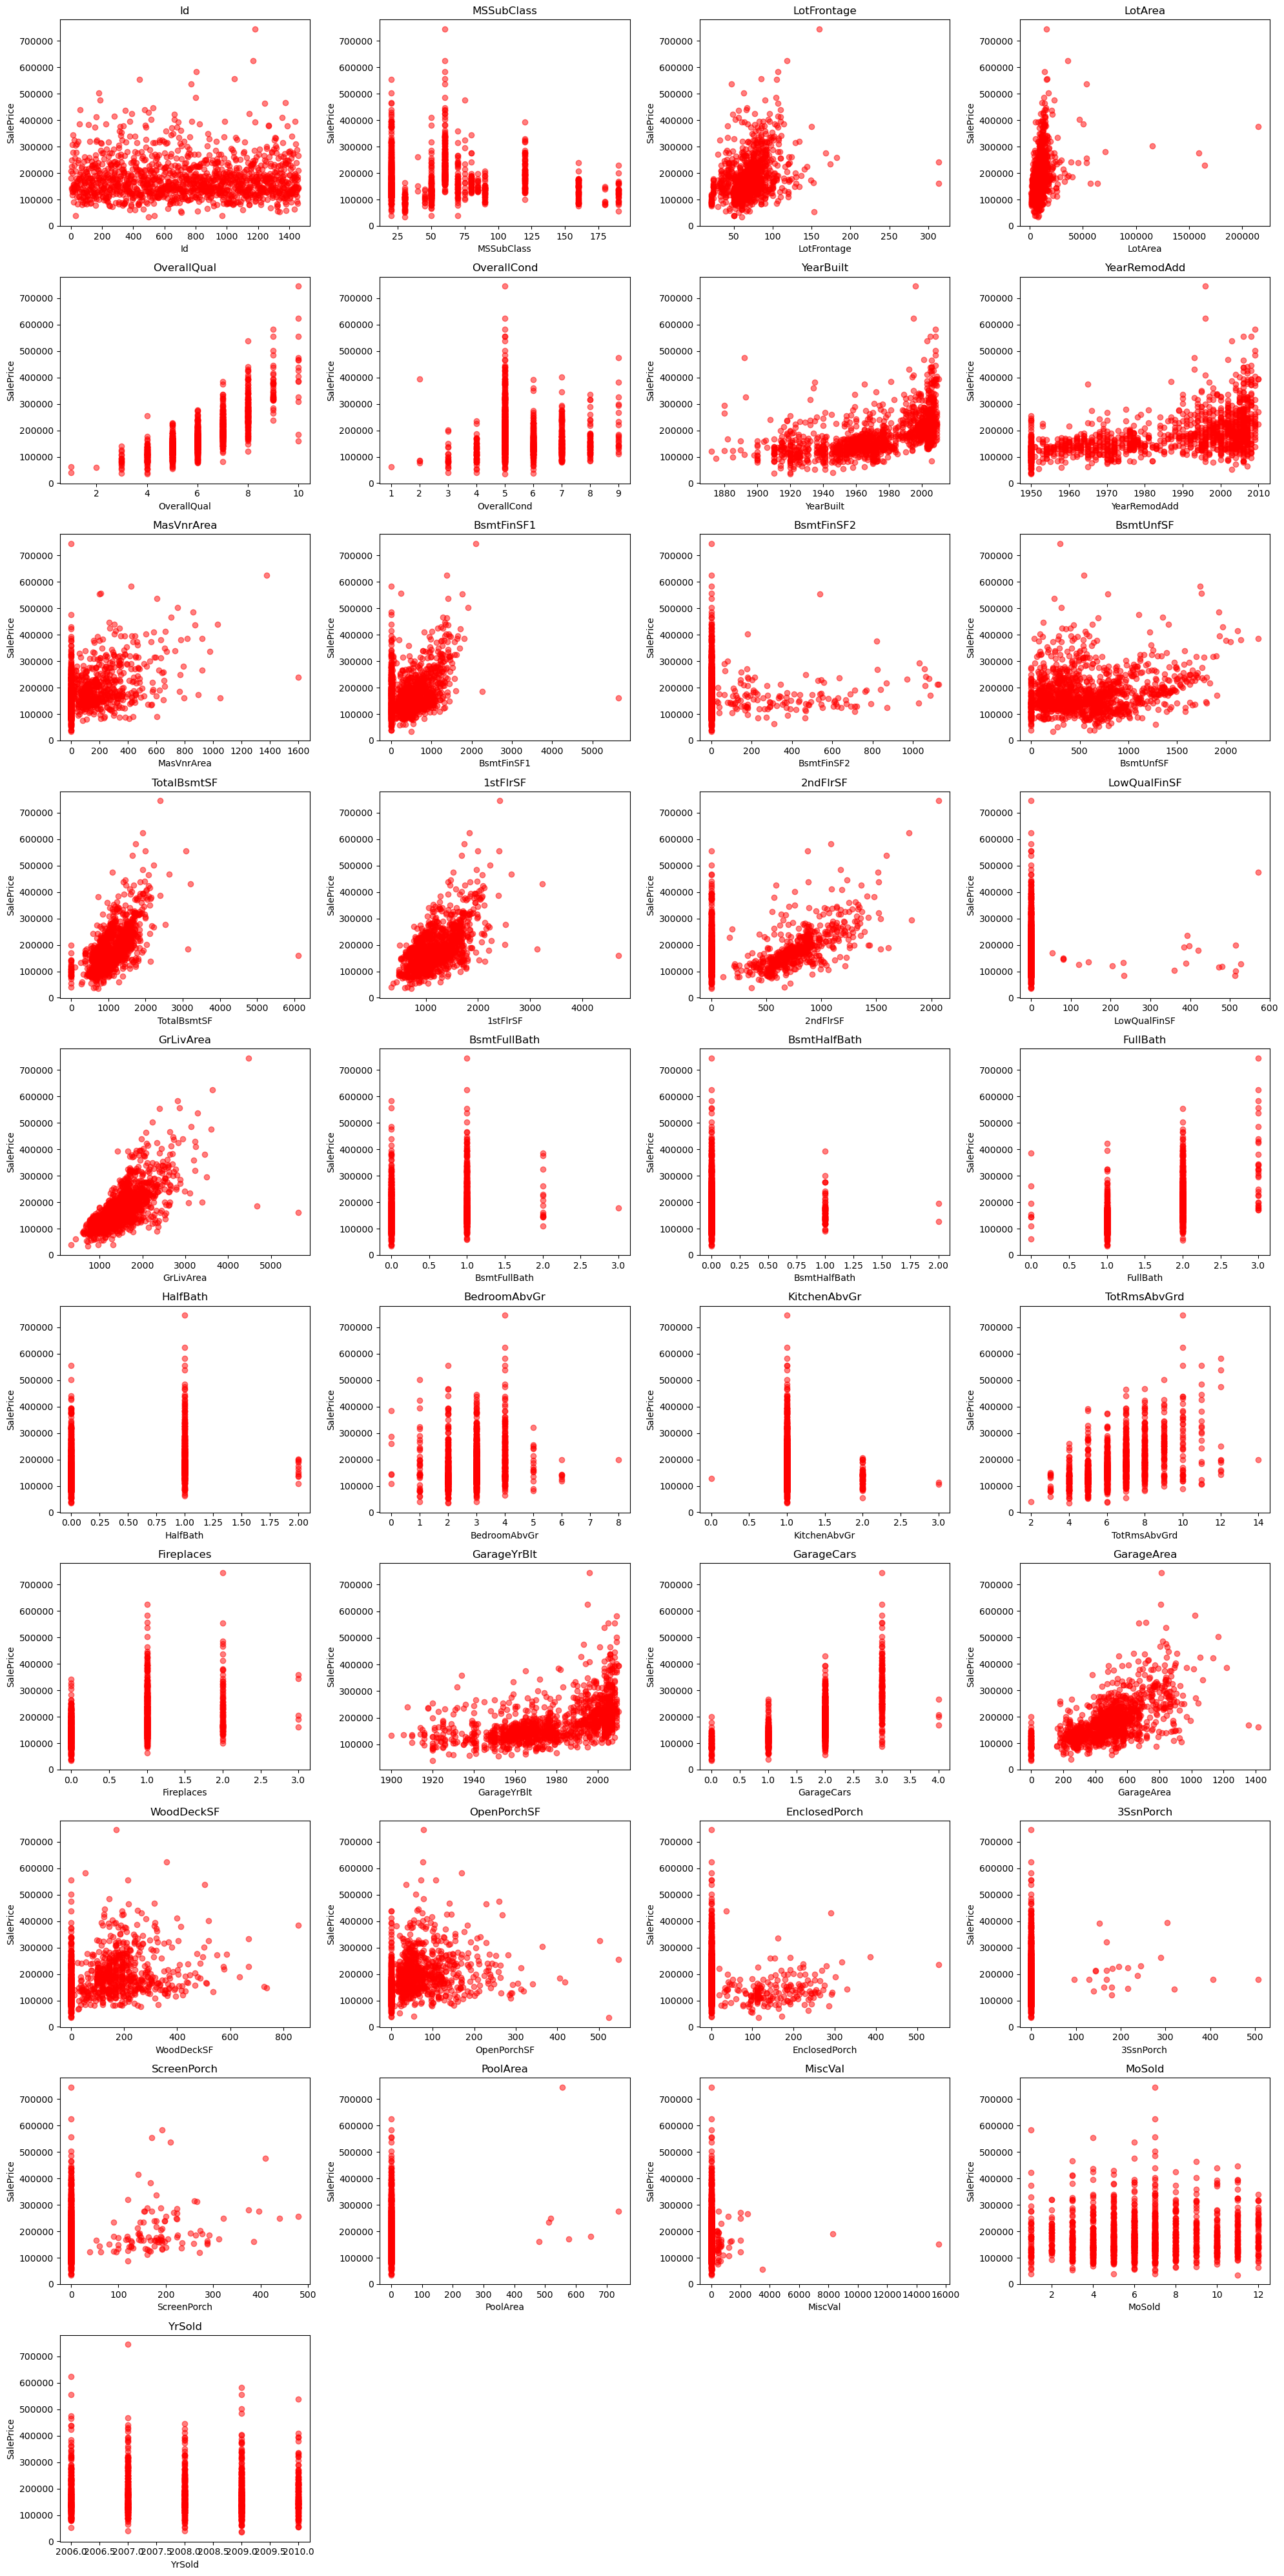

In [26]:
# numeric features
features = [col for col in train.select_dtypes(include=['number']).columns if col != 'SalePrice']

# grid size
n_cols = 4
n_rows = (len(features) + n_cols - 1) // n_cols

# subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

# scatter plots
for i, col in enumerate(features):
    axes[i].scatter(train[col], train['SalePrice'], alpha=0.5, color='red')
    axes[i].set_title(col)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('SalePrice')

# remove unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# show plots
plt.tight_layout()
plt.show()

### Inspection of categorical features

#### *Catplot of 'Neighborhood'*

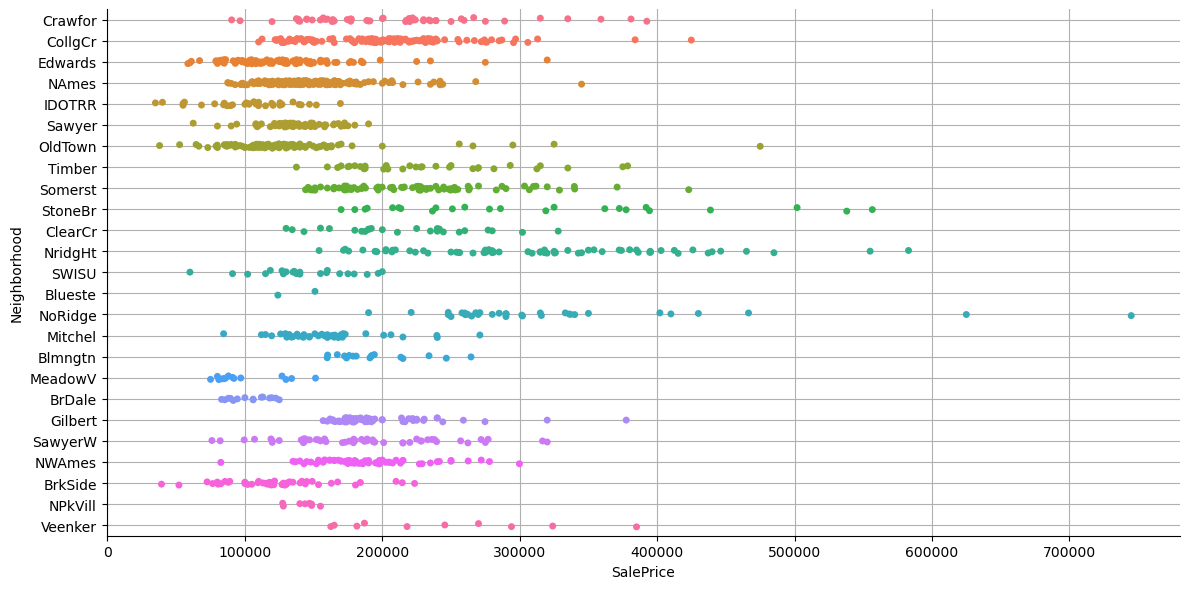

In [27]:
# catplot of neighborhood
sns.catplot(y= train['Neighborhood'], x= train['SalePrice'], data=train, hue = train['Neighborhood'], height=6, aspect=2)
plt.tight_layout()
plt.grid()
plt.show()

#### *Boxplots*

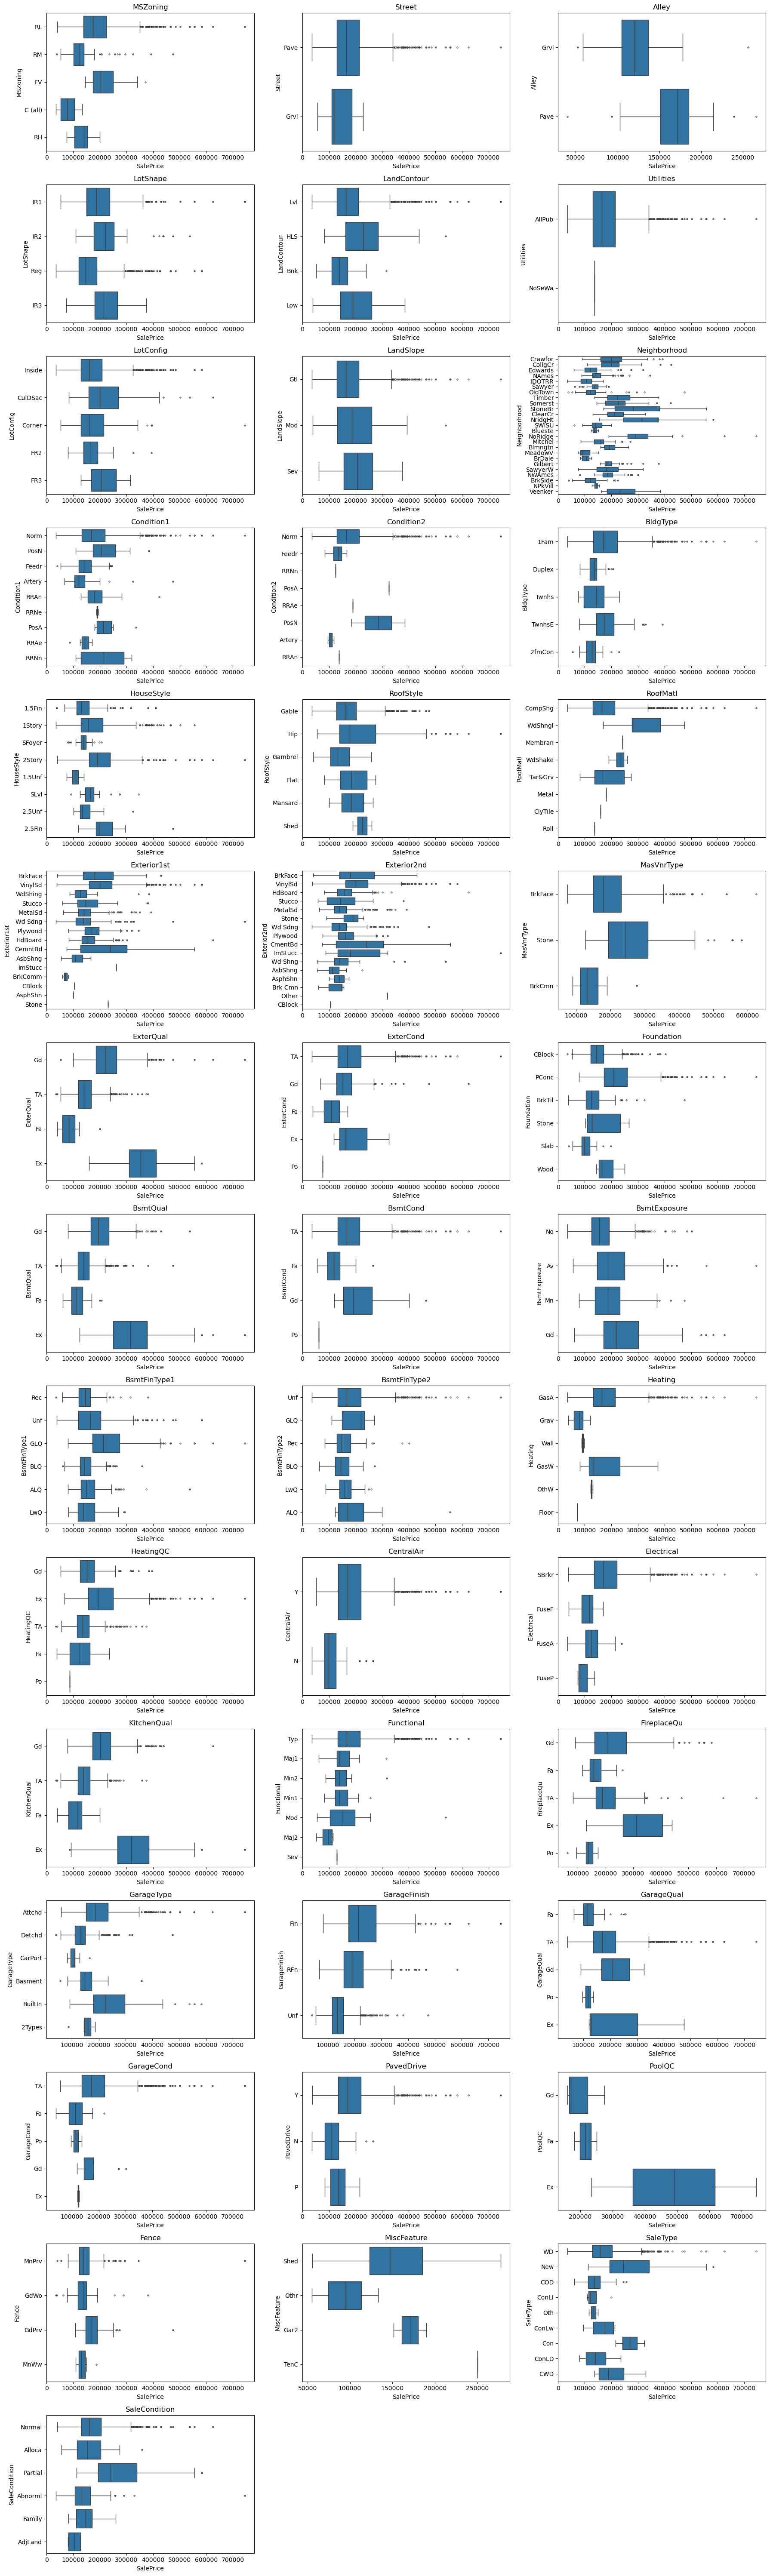

In [28]:
# select categorical columns
categorical_cols = [col for col in X_train.select_dtypes(include=["object", "category"]).columns]

# grid size
n_cols = 3
n_rows = -(-len(categorical_cols) // n_cols)

# plots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
axes = axes.flatten()

# each category
for ax, col in zip(axes, categorical_cols):
    sns.boxplot(
        data=train,
        x="SalePrice",
        y=col,
        ax=ax,
        fliersize=2,
        orient="h",
    )
    ax.set_title(col)
    ax.set_xlabel("SalePrice")
    ax.set_ylabel(col)

# remove unused subplots
for ax in axes[len(categorical_cols):]:
    ax.remove()

# show plot
plt.tight_layout()
plt.show()

### Missing values

In [29]:
# define threshold
threshold = 0.1

# calc na ratio
na_ratio = train.isna().mean()

# print the ones above threshold
print("Features that have over 10% of missing values:\n")
for i in na_ratio.index:
    if na_ratio[i] > threshold:
        print(i, ":", na_ratio[i])
        
# save them to a list
dropped_cols_na = na_ratio[na_ratio > threshold].index.tolist()

Features that have over 10% of missing values:

LotFrontage : 0.18036529680365296
Alley : 0.9345509893455098
MasVnrType : 0.5875190258751902
FireplaceQu : 0.4687975646879756
PoolQC : 0.9946727549467276
Fence : 0.8082191780821918
MiscFeature : 0.9619482496194824


### Feature Correlation

In [30]:
# compute correlation matrix
corr_matrix = train[features].corr(numeric_only=True)

# create list of tuples (col1, col2, corr_value)
corr_pairs = [
    (col1, col2, corr_matrix.loc[col1, col2])
    for i, col1 in enumerate(corr_matrix.columns)
    for j, col2 in enumerate(corr_matrix.columns)
    if i < j and abs(corr_matrix.loc[col1, col2]) > 0.6
]

# print them
print("Features that have correlation above 60%:\n")
for i in corr_pairs:
    print(i)

Features that have correlation above 60%:

('YearBuilt', 'GarageYrBlt', np.float64(0.8204857060314978))
('YearRemodAdd', 'GarageYrBlt', np.float64(0.643089641449772))
('BsmtFinSF1', 'BsmtFullBath', np.float64(0.6553270136178283))
('TotalBsmtSF', '1stFlrSF', np.float64(0.8251613542906705))
('2ndFlrSF', 'GrLivArea', np.float64(0.6850199163762811))
('2ndFlrSF', 'TotRmsAbvGrd', np.float64(0.616107178322972))
('GrLivArea', 'FullBath', np.float64(0.6195327284315008))
('GrLivArea', 'TotRmsAbvGrd', np.float64(0.8209850546794161))
('BedroomAbvGr', 'TotRmsAbvGrd', np.float64(0.6788197709240398))
('GarageCars', 'GarageArea', np.float64(0.8827714831961879))


### Skewness

In [31]:
# compute skewness for numeric columns
skew_vals = train[features + ['SalePrice']].select_dtypes(include='number').skew()

# select columns with skewness > 1.0
skewed_feats = skew_vals[skew_vals > 1.0].sort_values(ascending=False).index.tolist()

# print them
print("Features (and future target) that have skewness above 1.0:\n")
for i in skewed_feats:
    print(i, ":", skew_vals[i])

Features (and future target) that have skewness above 1.0:

MiscVal : 23.328471237684113
PoolArea : 14.058388254588772
LotArea : 11.873714950638474
3SsnPorch : 9.767732139677568
LowQualFinSF : 9.4373853815315
KitchenAbvGr : 4.383910188067092
BsmtFinSF2 : 4.333704342522787
ScreenPorch : 4.143901300371667
BsmtHalfBath : 4.119757709233
EnclosedPorch : 3.1160224114330775
MasVnrArea : 2.5805983321135035
OpenPorchSF : 2.3564024543275788
LotFrontage : 2.290395164438106
BsmtFinSF1 : 1.750859148262778
SalePrice : 1.7311709758534437
TotalBsmtSF : 1.6171009566442518
WoodDeckSF : 1.5764532662420732
GrLivArea : 1.3948014357171554
MSSubClass : 1.3935517061880938
1stFlrSF : 1.384414697614817


### Zeros

In [32]:
# get non-zero skewed feats (for log transformation)
non_zero_cols = [col for col in skewed_feats if (train[col] == 0).sum() == 0]

# not relevant in this setting
non_zero_cols.remove("MSSubClass")

# print
print("Columns that have skewness above 1, but have no values that are equal to 0:\n")
for i in non_zero_cols:
    print(i)

Columns that have skewness above 1, but have no values that are equal to 0:

LotArea
LotFrontage
SalePrice
GrLivArea
1stFlrSF


### Overview of features

In [33]:
# categorical
categorical_vars = [
    'MSZoning', 'Street', 'Alley', 'LandContour', 'Utilities', 'LotConfig',
    'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
    'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
    'Foundation', 'Heating', 'CentralAir', 'Electrical', 'Functional',
    'GarageType', 'GarageFinish', 'PavedDrive', 'Fence', 'PoolQC',
    'MiscFeature', 'SaleType', 'SaleCondition'
]

# ordinal
ordinal_vars = [
    'LotShape', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual',
    'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
    'HeatingQC', 'KitchenQual','FireplaceQu', 'GarageQual', 
    'GarageCond', 'PoolQC', 'Fence', 'Functional',
]

# numeric
numeric_vars = [
    'MSSubClass', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd',
    'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
    '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
    'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
    'Bedroom', 'Kitchen', 'TotRmsAbvGrd', 'Fireplaces',
    'GarageYrBlt', 'GarageCars', 'GarageArea',
    'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
    'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'OverallQual',
    'OverallCond',
]

# ordinal map
ordinal_mappings = {

    # 1-4 scale
    'BsmtExposure': {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4, 'NA': 0},
    'PoolQC': {'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4, 'NA': 0},
    'Fence': {'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4, 'NA': 0},
    
    # 1-5 scale
    'ExterQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'ExterCond': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'BsmtQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'NaN': 0},
    'BsmtCond': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'NA': 0},
    'HeatingQC': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'KitchenQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'FireplaceQu': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'NA': 0},
    'GarageQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'NA': 0},
    'GarageCond': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'NA': 0},

    # other scales (1-6, 4-1, 1-3, 1-8)
    'BsmtFinType1': {'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6, 'NA': 0},
    'BsmtFinType2': {'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6, 'NA': 0},
    'LotShape': {'Reg': 4, 'IR1': 3, 'IR2': 2, 'IR3': 1},
    'LandSlope': {'Gtl': 3, 'Mod': 2, 'Sev': 1},
    'Functional': {'Sal': 1, 'Sev': 2, 'Maj2': 3, 'Maj1': 4, 'Mod': 5, 'Min2': 6, 'Min1': 7, 'Typ': 8},
}

### Transformation

In [34]:
# transformation function (all decisions are based on information from the training data)
def transform_data(df):
    
    """Transformation function for train, test, and unseen data."""
    
    # drop Id column
    df = df.drop(columns=['Id'])
    
    # drop Utilities column (no relevant information)
    df = df.drop(columns=['Utilities'])
    
    # map ordinal variables
    for col, mapping in ordinal_mappings.items():
        if col in df.columns:
            df[col] = df[col].map(mapping)  # map known values
            df[col] = df[col].fillna(0)     # replace with 0
            
    # MasVnrArea
    df['MasVnrArea'] = df['MasVnrArea'].fillna(0)

    # drop columns with too many missing values
    df = df.drop(columns=dropped_cols_na)
    
    # drop highly correlated columns
    df = df.drop(columns=['TotRmsAbvGrd', 'GarageCars'])
    
    # existence of basement, garage, pool, porch
    df["Bsmt"] = np.where(df["TotalBsmtSF"].fillna(0) != 0, 1, 0)
    df["Garage"] = np.where(df["GarageArea"].fillna(0) != 0, 1, 0)
    df["Pool"] = np.where(df["PoolArea"].fillna(0) != 0, 1, 0)
    
    # total square footage
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df = df.drop(columns=['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'])
    
    # total bathrooms
    df['TotalBaths'] = df['FullBath'] + 0.5*df['HalfBath'] + df['BsmtFullBath'] + 0.5*df['BsmtHalfBath']
    df = df.drop(columns=['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath'])
    
    # house age
    df["HouseAge"] = df["YrSold"] - df["YearBuilt"]
    df = df.drop(columns=['YearBuilt'])
    
    # remodel age
    df["RemodAge"] = df["YrSold"] - df["YearRemodAdd"]
    df = df.drop(columns=['YearRemodAdd'])
            
    # treat some numeric vars as categorical
    for col in ['MSSubClass', 'MoSold', 'YrSold', 'GarageYrBlt']:
        if col in df.columns:
            df[col] = df[col].astype(str)
            
    # log transform skewed features, that have no 0s
    for col in non_zero_cols:
        if col in df.columns:
            df[col] = np.log1p(df[col])
            
    return df

# apply
train = transform_data(train)

### Encoding

In [35]:
# split features and target again
X_train = train.drop(columns=['SalePrice'])
y_train = train['SalePrice']

# one-hot encode
X_train = pd.get_dummies(X_train, dtype= "int")

## **Hyperparameter Tuning and Fitting**

### RandomForestRegressor, Optuna

In [36]:
# trial for RandomForestRegressor
def objective(trial):
    
    # hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 3, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    # model pipeline
    model = make_pipeline(
        SimpleImputer(strategy='mean'),
        RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            bootstrap=bootstrap,
            random_state=42,
            n_jobs=-1
        )
    )

    # cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring="r2").mean()

    # maximize R^2
    return score  

# optimization
study = opt.create_study(direction="maximize")
study.optimize(objective, n_trials=20, n_jobs=-1)

# show best trial
print("Best trial:")
print(f"  R^2: {study.best_value:.4f}")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

# create and train the final RandomForestRegressor model with best parameters
rfr_model = make_pipeline(
    SimpleImputer(strategy='mean'),
    RobustScaler(),
    RandomForestRegressor(
        n_estimators=study.best_params['n_estimators'],
        max_depth=study.best_params['max_depth'],
        min_samples_split=study.best_params['min_samples_split'],
        min_samples_leaf=study.best_params['min_samples_leaf'],
        max_features=study.best_params['max_features'],
        bootstrap=study.best_params['bootstrap'],
        random_state=42,
        n_jobs=-1
    )
)

# fit the model
rfr_model.fit(X_train, y_train)

# save model
joblib.dump(rfr_model, 'Cseresznyes_rfr_opt.pkl')

[I 2025-11-10 09:25:23,567] A new study created in memory with name: no-name-41e91b4b-0e7a-4509-ae2d-05a7d53e1176
[I 2025-11-10 09:26:12,706] Trial 6 finished with value: 0.7828655512841198 and parameters: {'n_estimators': 110, 'max_depth': 21, 'min_samples_split': 18, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True}. Best is trial 6 with value: 0.7828655512841198.
[I 2025-11-10 09:26:14,838] Trial 2 finished with value: 0.7435714968581959 and parameters: {'n_estimators': 118, 'max_depth': 7, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 6 with value: 0.7828655512841198.
[I 2025-11-10 09:26:40,158] Trial 0 finished with value: 0.8537451623460299 and parameters: {'n_estimators': 442, 'max_depth': 27, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.8537451623460299.
[I 2025-11-10 09:26:49,112] Trial 7 finished with value: 0.78918953633632

Best trial:
  R^2: 0.8666
  n_estimators: 374
  max_depth: 25
  min_samples_split: 4
  min_samples_leaf: 3
  max_features: None
  bootstrap: True


['Cseresznyes_rfr_opt.pkl']

### Lasso, Optuna

In [37]:
# trial for Lasso Regression
def objective(trial):
    
    # hyperparameter
    alpha = trial.suggest_loguniform('alpha', 1e-4, 10.0)

    # model pipeline
    model = make_pipeline(
        SimpleImputer(strategy='mean'),
        RobustScaler(),
        Lasso(alpha=alpha, random_state=42, max_iter=10000)
    )

    # cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # deal with convergence warnings
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        score = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2').mean()
    
    # maximize R^2
    return score  

# optimization
study = opt.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# show best trial
print('Best trial:')
print(f'  R^2: {study.best_value:.4f}')
print(f'  alpha: {study.best_params["alpha"]:.6f}')

# create and train the final Lasso model with best parameters
lasso_model = make_pipeline(
    SimpleImputer(strategy='mean'),
    RobustScaler(),
    Lasso(alpha=study.best_params['alpha'], random_state=42, max_iter=10000)
)

# fit the model
lasso_model.fit(X_train, y_train)

# save model
joblib.dump(lasso_model, 'Cseresznyes_las_opt.pkl')

[I 2025-11-10 09:30:37,332] A new study created in memory with name: no-name-1b331733-5b10-4088-93f7-2b779559ad3f
[I 2025-11-10 09:30:38,564] Trial 0 finished with value: 0.8579194098242052 and parameters: {'alpha': 0.004507604473258412}. Best is trial 0 with value: 0.8579194098242052.
[I 2025-11-10 09:30:39,635] Trial 1 finished with value: 0.7853007052323429 and parameters: {'alpha': 0.03884045649618291}. Best is trial 0 with value: 0.8579194098242052.
[I 2025-11-10 09:30:41,328] Trial 2 finished with value: 0.8815487267841583 and parameters: {'alpha': 0.0003345553417599575}. Best is trial 2 with value: 0.8815487267841583.
[I 2025-11-10 09:30:42,223] Trial 3 finished with value: 0.29975875844557276 and parameters: {'alpha': 0.22607427624778076}. Best is trial 2 with value: 0.8815487267841583.
[I 2025-11-10 09:30:43,250] Trial 4 finished with value: 0.8774277658846105 and parameters: {'alpha': 0.0011351274735590746}. Best is trial 2 with value: 0.8815487267841583.
[I 2025-11-10 09:30:

Best trial:
  R^2: 0.8824
  alpha: 0.000389


['Cseresznyes_las_opt.pkl']

### XGBRegressor, Optuna

In [38]:
# trial for XGBoost Regressor
def objective(trial):
    
    # hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1.5),
        'random_state': 42,
        'n_jobs': -1,
        'objective': 'reg:squarederror'
    }

    # create model
    model = XGBRegressor(**params)

    # cross-validation, using neg MSE
    scores = cross_val_score(
        model, X_train, y_train,
        scoring='neg_mean_squared_error',
        cv=5,
        n_jobs=-1
    )

    # minimize RMSE
    rmse = np.sqrt(-scores.mean())
    return rmse


# optimization
study = opt.create_study(direction='minimize', study_name='xgb_regression_opt')
study.optimize(objective, n_trials=20, n_jobs=1, show_progress_bar=True)

# show best trial
print("Best trial:")
print("Best RMSE (CV):", study.best_value)
print("Best Parameters:", study.best_params)

# create and train the final XGBoost model with best parameters
xgb_model = make_pipeline(
    SimpleImputer(strategy='mean'),
    RobustScaler(),
    XGBRegressor(
        **study.best_params,
        random_state=42,
        n_jobs=-1,
        objective='reg:squarederror'
    )
)

# fit the model
xgb_model.fit(X_train, y_train)

# save model
joblib.dump(xgb_model, 'Cseresznyes_xgbr_opt.pkl')

[I 2025-11-10 09:31:02,800] A new study created in memory with name: xgb_regression_opt


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-11-10 09:31:20,310] Trial 0 finished with value: 0.14149851002544456 and parameters: {'n_estimators': 450, 'max_depth': 8, 'learning_rate': 0.021432093581478608, 'subsample': 0.9482226771941079, 'colsample_bytree': 0.7336781964237468, 'gamma': 0.33552738366409995}. Best is trial 0 with value: 0.14149851002544456.
[I 2025-11-10 09:31:29,358] Trial 1 finished with value: 0.1606486936138101 and parameters: {'n_estimators': 450, 'max_depth': 5, 'learning_rate': 0.017886337668869837, 'subsample': 0.7415733830449937, 'colsample_bytree': 0.9382194235127332, 'gamma': 1.4515492053933736}. Best is trial 0 with value: 0.14149851002544456.
[I 2025-11-10 09:31:31,659] Trial 2 finished with value: 0.1478733817989248 and parameters: {'n_estimators': 250, 'max_depth': 7, 'learning_rate': 0.021891348134321986, 'subsample': 0.6314401836017476, 'colsample_bytree': 0.6322475820965838, 'gamma': 0.6605973069132705}. Best is trial 0 with value: 0.14149851002544456.
[I 2025-11-10 09:31:34,193] Trial 3

['Cseresznyes_xgbr_opt.pkl']

### GradientBoostingRegressor, Optuna

In [39]:
# trial for Gradient Boosting Regressor 
def objective(trial):
    
    # hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
    }

    # create pipeline with preprocessing and model
    model = make_pipeline(
        SimpleImputer(strategy='mean'),
        RobustScaler(),
        GradientBoostingRegressor(
            **params,
            random_state=42
        )
    )

    # cross-validation, using neg MSE
    scores = cross_val_score(
        model, X_train, y_train,
        scoring='neg_mean_squared_error',
        cv=5,
        n_jobs=-1
    )

    # minimize RMSE
    rmse = np.sqrt(-scores.mean())
    return rmse


# optimization
study = opt.create_study(direction='minimize', study_name='gbr_regression_opt')
study.optimize(objective, n_trials=20, n_jobs=1, show_progress_bar=True)

# show best trial
print("Best trial:")
print("Best RMSE (CV):", study.best_value)
print("Best Parameters:", study.best_params)

# create and train the final Gradient Boosting model with best parameters
gbr_model = make_pipeline(
    SimpleImputer(strategy='mean'),
    RobustScaler(),
    GradientBoostingRegressor(
        **study.best_params,
        random_state=42
    )
)

# fit the model
gbr_model.fit(X_train, y_train)

# save model
joblib.dump(gbr_model, 'Cseresznyes_gbr_opt.pkl')

[I 2025-11-10 09:32:11,162] A new study created in memory with name: gbr_regression_opt


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-11-10 09:32:19,181] Trial 0 finished with value: 0.13651353139677017 and parameters: {'n_estimators': 150, 'max_depth': 9, 'learning_rate': 0.020464034794125802, 'subsample': 0.7324261085978931, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.13651353139677017.
[I 2025-11-10 09:32:43,765] Trial 1 finished with value: 0.13889098714612969 and parameters: {'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.14916268770457167, 'subsample': 0.9122786714684208, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.13651353139677017.
[I 2025-11-10 09:33:07,517] Trial 2 finished with value: 0.14017049272077947 and parameters: {'n_estimators': 400, 'max_depth': 8, 'learning_rate': 0.017337371797510118, 'subsample': 0.9940976136073724, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.13651353139677017.
[I 2025-11-10 09:33:15,662] Trial 3 finished with value: 0.15039083106035983 and parameters: {'n_est

['Cseresznyes_gbr_opt.pkl']

### Stacked Regressor

In [40]:
# define base learners
estimators = [
    ('lasso', lasso_model),
    ('xgbr', xgb_model),
    ('rfr',  rfr_model),
    ('gbr',  gbr_model)
]

# define meta-learner (the "stacking" model)
final_estimator = RidgeCV()

# build stacked model pipeline
stacked_model = make_pipeline(
    SimpleImputer(strategy='mean'),
    RobustScaler(),
    StackingRegressor(
        estimators=estimators,
        final_estimator=final_estimator,
        n_jobs=-1,
        passthrough=True   # meta-learner sees both features + base model preds
    )
)

# fit on training data
stacked_model.fit(X_train, y_train)

# save model
joblib.dump(stacked_model, 'Cseresznyes_stacked.pkl')

['Cseresznyes_stacked.pkl']

## **Evaluation and Prediction**

### Test Prediction

#### *Predictions on Test and Evaluation of Models*

In [41]:
# transformation and encoding
X_test = transform_data(X_test)
X_test = pd.get_dummies(X_test, dtype= "int")

# align test features with training features
train_columns = X_train.columns.tolist()
for col in train_columns:
    if col not in X_test.columns:
        X_test[col] = 0
        
# reorder columns to match training set
X_test = X_test[train_columns]

# predictions
y_tr_las = lasso_model.predict(X_test)
y_tr_xgb = xgb_model.predict(X_test)
y_tr_rfr = rfr_model.predict(X_test)
y_tr_gbr = gbr_model.predict(X_test)
y_tr_stack = stacked_model.predict(X_test)

# metrics function
def print_metrics(y_true, y_pred, model_name):
    
    """Function to print metrics of models for evaluation."""
    
    # mean squared error
    mse = mean_squared_error(y_true, y_pred)
    
    # root mean squared error
    rmse = np.sqrt(mse)
    
    # mean absolute error
    mae = mean_absolute_error(y_true, y_pred)
    
    # r squared
    r2 = r2_score(y_true, y_pred)
    
    # print metrics
    print(f"{model_name} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, R^2: {r2:.4f}")

# print metrics for each model
print_metrics(y_test, np.expm1(y_tr_rfr), "RandomForestRegressor Model")
print_metrics(y_test, np.expm1(y_tr_las), "Lasso Model")
print_metrics(y_test, np.expm1(y_tr_xgb), "XGBRegressor Model")
print_metrics(y_test, np.expm1(y_tr_gbr), "GradientBoostingRegressor Model")
print_metrics(y_test, ((np.expm1(y_tr_rfr) + np.expm1(y_tr_las) + np.expm1(y_tr_xgb) + np.expm1(y_tr_gbr)) / 4), "Averaged Model")
print_metrics(y_test, np.expm1(y_tr_stack), "Stacked Model")

# df with true and predicted values
test_df = pd.DataFrame({
    'SalePrice': y_test,
    'SalePrice (RFR)': np.expm1(y_tr_rfr),
    'SalePrice (Lasso)': np.expm1(y_tr_las),
    'SalePrice (XGBR)': np.expm1(y_tr_xgb),
    'SalePrice (GBR)': np.expm1(y_tr_gbr),
    'SalePrice (average)': ((np.expm1(y_tr_rfr) + np.expm1(y_tr_las) + np.expm1(y_tr_xgb) + np.expm1(y_tr_gbr)) / 4),
    'SalePrice (stacked)': np.expm1(y_tr_stack)
})

# ceiling
test_df["SalePrice (stacked)"] = test_df["SalePrice (stacked)"].apply(lambda x: math.ceil(x / 1000) * 1000)
test_df["SalePrice (average)"] = test_df["SalePrice (average)"].apply(lambda x: math.ceil(x / 1000) * 1000)

# show first 10 rows
test_df.head(10)

RandomForestRegressor Model - RMSE: 34732.9359, MAE: 17166.1380, R^2: 0.8680
Lasso Model - RMSE: 26768.1545, MAE: 14701.2559, R^2: 0.9216
XGBRegressor Model - RMSE: 30425.4325, MAE: 16945.0176, R^2: 0.8987
GradientBoostingRegressor Model - RMSE: 31668.2274, MAE: 14900.6134, R^2: 0.8902
Averaged Model - RMSE: 29882.4446, MAE: 14707.5869, R^2: 0.9023
Stacked Model - RMSE: 22194.1709, MAE: 14117.0291, R^2: 0.9461


,SalePrice,SalePrice (RFR),SalePrice (Lasso),SalePrice (XGBR),SalePrice (GBR),SalePrice (average),SalePrice (stacked)
892,154500,143853.463077,148222.553748,138210.218750,144914.983230,144000,148000
1105,325000,327374.104288,325628.496975,309771.312500,335418.825776,325000,334000
413,115000,110363.503647,101343.962581,101338.328125,108320.175278,106000,99000
522,159000,152294.812726,162557.511139,164795.468750,154753.434893,159000,165000
1036,315500,303725.131996,314728.997519,298681.031250,321485.950702,310000,329000
614,75500,85153.521591,79833.325556,90534.554688,79602.053742,84000,83000
218,311500,198312.083754,254014.983587,206051.765625,231649.144741,223000,245000
1160,146000,151754.151495,133488.654790,152553.031250,147154.054776,147000,134000
649,84500,83573.336534,79099.859451,90379.359375,79047.310383,84000,82000
887,135500,136211.763724,147527.139158,136306.937500,143272.471481,141000,147000


#### *Visualization of prediction*

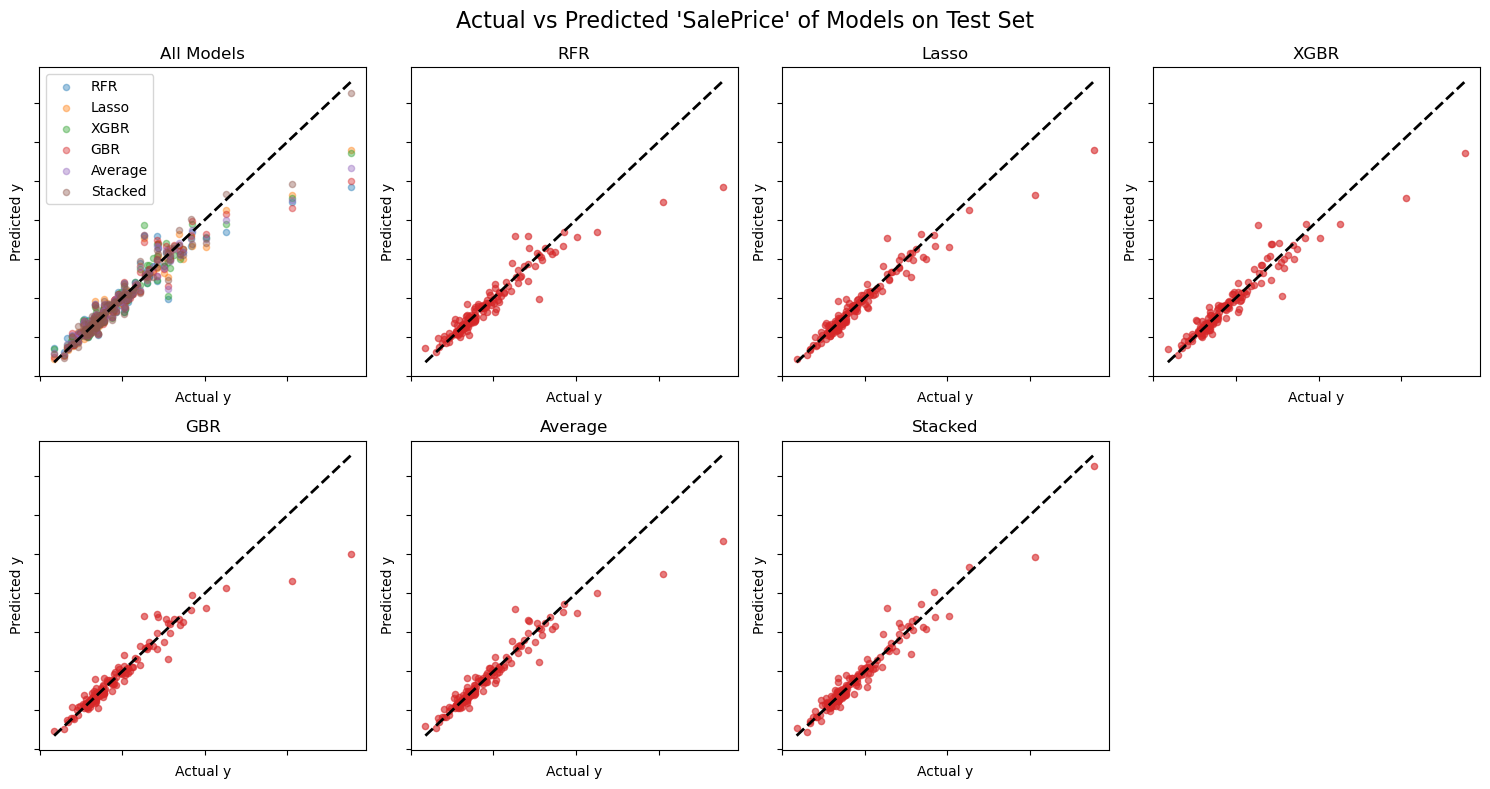

In [42]:
# model dict
model_preds = {
    "RFR": test_df["SalePrice (RFR)"],
    "Lasso": test_df["SalePrice (Lasso)"],
    "XGBR": test_df["SalePrice (XGBR)"],
    "GBR": test_df["SalePrice (GBR)"],
    "Average": test_df['SalePrice (average)'],
    "Stacked": test_df["SalePrice (stacked)"]
}

# actual y
y_actual = test_df["SalePrice"]

# set figure
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()
fig.suptitle("Actual vs Predicted 'SalePrice' of Models on Test Set", fontsize=16)

# all models on one plot
for name, y_pred in model_preds.items():
    axes[0].scatter(y_actual, y_pred, alpha=0.4, label=name, s=20)
min_val, max_val = y_actual.min(), y_actual.max()
axes[0].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
axes[0].set_title("All Models")
axes[0].set_xlabel("Actual y")
axes[0].set_ylabel("Predicted y")
axes[0].legend()
axes[0].set_xticklabels([])
axes[0].set_yticklabels([])

# one subplot for every model
for i, (name, y_pred) in enumerate(model_preds.items(), start=1):
    axes[i].scatter(y_actual, y_pred, alpha=0.6, color="tab:red", s=20)
    axes[i].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
    axes[i].set_title(name)
    axes[i].set_xlabel("Actual y")
    axes[i].set_ylabel("Predicted y")
    axes[i].set_xticklabels([])
    axes[i].set_yticklabels([])

# hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# show
plt.tight_layout()
plt.show()

### Predicting on Unseen Data (Kaggle)

In [43]:
# load kaggle set and keep Id for submission
kaggle = pd.read_csv('test.csv')
kaggle_id = kaggle['Id'].copy()

# preprocess kaggle features
kaggle = transform_data(kaggle)
kaggle = pd.get_dummies(kaggle, dtype= "int")

# align kaggle features with training features
for col in train_columns:
    if col not in kaggle.columns:
        kaggle[col] = 0

# reorder columns to match training set
kaggle = kaggle[train_columns]

# predict and transform back
y_hat_las = np.expm1(lasso_model.predict(kaggle))
y_hat_xgb = np.expm1(xgb_model.predict(kaggle))
y_hat_rfr = np.expm1(rfr_model.predict(kaggle))
y_hat_gbr = np.expm1(gbr_model.predict(kaggle))
y_hat_stacked = np.expm1(stacked_model.predict(kaggle))

# prepare a result dataframe
kaggle_df = pd.DataFrame({
    'Id': kaggle_id,
    'SalePrice (RFR, Optuna)': y_hat_rfr,
    'SalePrice (Lasso, Optuna)': y_hat_las,
    'SalePrice (XGBR, Optuna)': y_hat_xgb,
    'SalePrice (GBR)': y_hat_gbr,
    'SalePrice (average)': ((y_hat_rfr + y_hat_las + y_hat_xgb + y_hat_gbr) / 4),
    'SalePrice': y_hat_stacked
})

# round up
kaggle_df["SalePrice"] = kaggle_df["SalePrice"].apply(lambda x: math.ceil(x / 1000) * 1000)

# show first 10 rows
kaggle_df.head(10)

,Id,"SalePrice (RFR, Optuna)","SalePrice (Lasso, Optuna)","SalePrice (XGBR, Optuna)",SalePrice (GBR),SalePrice (average),SalePrice
0,1461,122259.426950,121657.227114,129327.390625,128378.081255,125405.531486,125000
1,1462,158452.198955,152682.383637,156049.703125,163296.126179,157620.102974,131000
2,1463,176629.220445,178774.484831,182245.125000,184960.306552,180652.284207,186000
3,1464,183592.851374,195069.757068,185400.421875,193657.612347,189430.160666,196000
4,1465,192887.381003,201695.393815,183799.781250,187123.501007,191376.514269,182000
5,1466,179854.732528,170340.750543,176844.984375,173006.970754,175011.859550,170000
6,1467,175099.630109,180183.544178,171678.843750,178604.830110,176391.712037,167000
7,1468,175590.778030,162381.870277,171618.937500,168560.930029,169538.128959,162000
8,1469,192508.196521,192732.941368,187614.312500,194312.868858,191792.079812,180000
9,1470,124924.380508,117349.619484,125709.914062,121618.938984,122400.713260,118000


### Saving predictions

In [44]:
# generate filename
filename = 'Cseresznyes_house_prices_pred_' + str(datetime.today().strftime('%Y%m%d%H%M')) + '.csv'
print(f"(ᵔᴥᵔ) Predictions saved to: '{filename}'. (ᵔᴥᵔ)\n")

# save to csv for submission
kaggle_df[["Id", "SalePrice"]].to_csv(filename, index=False)

# end running time
end_time = time.time()
elapsed = end_time - start_time
minutes, seconds = divmod(elapsed, 60)
print(f"This Notebbok ran for a total of {int(minutes)} minutes {seconds:.1f} seconds.")

(ᵔᴥᵔ) Predictions saved to: 'Cseresznyes_house_prices_pred_202511100936.csv'. (ᵔᴥᵔ)

This Notebbok ran for a total of 12 minutes 10.7 seconds.


## **Discussion**

My workflow for the House Prices Kaggle Competition consisted of three sections: **Data Preparation and Feature Enginnering**, **Hyperparameter Tuning and Fitting**, and **Evaluation and Prediction**. In the first section, I inspected data from the training set and made decisions for transforming it in meaningful ways (for the models to work smoothly and to avoid overfitting). In the second section, I 'tuned' four different models using Optuna and fitted them to the training data, then used a stacked regressor to have a weighted combination of them. In the last section, I evaluated the models on a test set and predicted on the unseen data from Kaggle.

After loading the data (*train.csv*), I splitted it into 95% training and 5% test set for later evaluation. I printed the histograms and scatter plots (against *SalePrice*) of numeric columns. At a first glance of the histograms, it was obvious that there exists an *Id* column, which needs to be dropped. There were numeric values which are only informative as categories (*MSSubClass*, *MoSold*, *YrSold*, *GarageYrBlt*), and that some (continuous) features seemed to be skewed. The scatter plots illustrated well that there are groups of features which have many zeros based on their existence or not (Basement, Garage, Pool). I looked at the correlation between features above the threshold of 0.6, but only decided to drop *TotRmsAbvGrd* (correlation with *GrLivArea* was 0.83, with *2ndFlrSF* was 0.62, with *BedroomAbvGr* it was 0.68) and *GarageCars* (correlated with *OverallQual* 0.60, with *GarageArea* 0.88), because the other columns (that were highly correlated) were to be treated differently later (Dates, Areas, Baths). My assumption was that based on the skewness and number of zeros, I could select columns suitable for log-transformation to treat outliers better (the number of zeros is important due to the argument of the logarithm). There were twenty columns with skewness above 1, but only five of them had no zero datapoints, these were log-transformed: the target *SalePrice*, and features *LotArea*, *1stFlrSF*, *GrLivArea*.

I created new, in my opinion, more general, and possibly more informative features by combining existing features, and then removed the originals. First, I calculated the total area of each house by summing the basement, first-floor, and second-floor areas into the *TotalSF* variable. Next, I derived a total bathroom count (*TotalBaths*) from combining full and half bathrooms using weights. I computed the age of the house (*HouseAge*) with the year built and sold, and the time since the last remodel (*RemodAge*). I kept *YrSold* as a categorical feature. I also created binary indicators showing whether a house has a basement, garage, or pool based on the corresponding zero-nonzeroarea values.

For categorical features, I printed the boxplots (against *SalePrice*) of categorical features and saw that *Utilities* is irrelevant, as all observations are the same except one, and more importantly, that there are features which are ordinal and more relevant if treated as numerical than categorical: (*LotShape*, *LandSlope*, *ExterQual*, *ExterCond*, *BsmtQual*, *BsmtCond*, *BsmtExposure*, *BsmtFinType1*, *BsmtFinType2*, *HeatingQC*, *KitchenQual*, *FireplaceQu*, *GarageQual*, *GarageCond*, *PoolQC*, *Fence*, *Functional*). I created a mapping based on the number and order of categories.

I set a threshold of 0.1 for all features: any column with a higher proportion of missing values was removed. These columns were dropped: *LotFrontage*, *Alley*, *MasVnrType*, *FireplaceQu*, *PoolQC*, *Fence*, *MiscFeature*. My strategy for missing values for some numeric columns was filling with 0, which is a limitation of my model. In order to transform the test data the same way, I very simply created a *transform(df)* function that makes changes on the data in its argument. The decisions of changes were strictly based on information from the training set. At the end of this section, I encoded categorical columns to binary (0–1).

I decided on four models to tune with *Optuna*: *RandomForestRegressor*, *Lasso*, *XGBRegressor*, and *GradientBoostingRegressor*. I chose *Optuna*, because it optimizes the search for the best parameters. My main idea was to select models that differ in terms of approach (tree or linear) and complexity in order to have multiple estimates in prediction when combined. The data was scaled by *RobustScaler* for all models. For *Lasso*, it was to handle outliers better, for the rest it was to keep the reshaping of the log-transformation in bounds. The *SimpleImputer* strategy was set to *mean* for *Lasso*, *RandomForestRegressor*, and *GradientBoostingRegressor*. The pipeline for all models performed 5-fold cross-validation, the best hyperparameters were selected by *Optuna* after 20 trials of each model.

I chose *RandomForestRegressor* to have a simpler decision tree-, ensemble-based model, that is robust. I selected *Lasso* to have a linear model in my combination, which has a reduced complexity. I added *XGBRegressor*, which is also tree based, but uses a gradient boosting algorithm. I decided to have *GradientBoostingRegressor* as my fourth model, which is similar to *XGBRegressor*, but less robust. (To be honest, I was just curious to see how it performs, and it did well, so I decided to keep it in the end.)

The models performed relatively well on the test set:

$$
R_{RFR}^2 = 0.85
$$

$$
R_{LASSO}^2 = 0.91
$$

$$
R_{XGBR}^2 = 0.91
$$ 

$$
R_{GBR}^2 = 0.89
$$

$$
R_{AVERAGED}^2 = 0.89
$$

$$
R_{STACKED}^2 = 0.89
$$

However, after seeing the visualization of predictions on the test set, the models tended to underestimate the prices of higher-valued houses. The combined models (stacked regressor and averaging of the predictions of the four models) helped stabilize performance and improve generalization a little, but not a lot. The final predictions by the stacked regressor were rounded up (ceiling) to thousands, because rounded house prices are more general in reality. A possible limitation of evaluation and prediction is that when loading the test and the unseen set, there were mismatches in columns (based on the encodings of categorical data), which were simply filled by zeros.

Overall, the models performed well in the end, scoring $0.12205$ on Kaggle at best. I spent the most time on data preparation and feature engineering, more specifically, thinking on what steps need to be taken: transformations, new features, interaction terms, etc. In the end, I stuck with a general, simple pipeline for the models. I learned a lot about the models I chose by applying them. As I stated before, one of the main limitations of my model is the handling of missing values. My model could also be improved by creating new, more relevant features. What I also missed was looking at feature importance and coefficients, which could provide us information about which features influence house prices the most. (In the setting of the Kaggle competition, this was not important to include, but still.)
